## Organize simulations

Purpose:
This script loads all .pkl files from the `data/raw` directory, each containing simulation results (e.g., configurations and polarization curves) that we have generated so far.

For each .pkl file:
- It checks if the file contains a pandas DataFrame
- It adds a `file_source` column with the filename for traceability
- It appends it to a list of DataFrames

At the end, all valid DataFrames are concatenated into a single combined DataFrame called `combined_df`, which can be used for further processing (e.g., labeling valid/invalid polarization curves, training classifiers and running IRD analysis)

In [134]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from datetime import datetime, date
from openpyxl import load_workbook
from openpyxl.worksheet.table import Table, TableStyleInfo
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import sys
sys.path.append("../external/AlphaPEM")

In [2]:
# Path to all the results from previous simulations ("raw" data)
data_path = r"..\data\raw" 

# Find all .pkl files
pkl_files = glob.glob(os.path.join(data_path, "*.pkl"))  # From the general folder
pkl_files = pkl_files + glob.glob(os.path.join(data_path + r"\final_data_sobol_sampling", "*.pkl"))

print(pkl_files)

['..\\data\\raw\\LHS_seed42_nsamples100_ndimensions16_bounds25.pkl', '..\\data\\raw\\LHS_seed42_nsamples160_ndimensions16.pkl', '..\\data\\raw\\morris_sample_results_N10_lev4.pkl', '..\\data\\raw\\morris_sample_results_N10_lev4_corrected.pkl', '..\\data\\raw\\N10_levels4_seed42.pkl', '..\\data\\raw\\PDP_20_default.pkl', '..\\data\\raw\\PDP_20_default_updated.pkl', '..\\data\\raw\\PDP_Sc_Phi_c_des_default.pkl', '..\\data\\raw\\results.pkl', '..\\data\\raw\\sobol_1_seed42.pkl', '..\\data\\raw\\sobol_N10_seed42.pkl', '..\\data\\raw\\sobol_sampling_configurations_cmpl_kappa_c.pkl', '..\\data\\raw\\try_combinations_after_rev_conf2.pkl', '..\\data\\raw\\try_combinations_after_rev_conf3.pkl', '..\\data\\raw\\final_data_sobol_sampling\\results_sobol_sampling_middle_nathaly.pkl', '..\\data\\raw\\final_data_sobol_sampling\\sample_sobol_camila.pkl', '..\\data\\raw\\final_data_sobol_sampling\\sobol_dejvis.pkl']


In [35]:
all_dfs = []

for file in pkl_files:
    try:
        obj = pd.read_pickle(file)

        if isinstance(obj, pd.DataFrame):
            df = obj
        elif isinstance(obj, list) and all(isinstance(item, dict) for item in obj):
            df = pd.DataFrame(obj)
        else:
            print(f"Skipped {file}: not a DataFrame or list of dicts")
            continue

        # Ensure 'Re' is float64 if it exists
        if "Re" in df.columns:
            df["Re"] = df["Re"].astype("float64")

        df["file_source"] = os.path.basename(file)
        all_dfs.append(df)

    except Exception as e:
        print(f"Error reading {file}: {e}")


# Concatenate all loaded data
if all_dfs:
    combined_df = pd.concat(all_dfs, ignore_index=True)
    combined_df = combined_df.dropna(axis = 0, how = "any")
    print("Loaded and combined", len(all_dfs), "files.")
    print("Shape:", combined_df.shape)
    print("Columns:", combined_df.columns.tolist())
else:
    print("No valid dfs loaded.")

combined_df["file_source"] = combined_df["file_source"].astype("str")

Loaded and combined 17 files.
Shape: (18391, 49)
Columns: ['Tfc', 'Pa_des', 'Sc', 'Phi_c_des', 'epsilon_gdl', 'tau', 'epsilon_mc', 'epsilon_c', 'e', 'Re', 'i0_c_ref', 'kappa_co', 'kappa_c', 'a_slim', 'b_slim', 'a_switch', 'Pc_des', 't_step', 'i_step', 'delta_pola', 'i_EIS', 'ratio_EIS', 'f_EIS', 't_EIS', 'current_density', 'max_step', 'n_gdl', 't_purge', 'type_fuel_cell', 'type_current', 'type_auxiliary', 'type_control', 'type_purge', 'type_display', 'type_plot', 'C_scl', 'i_max_pola', 'Aact', 'Hgdl', 'Hmem', 'Hcl', 'Hgc', 'Wgc', 'Lgc', 'Sa', 'Phi_a_des', 'ifc', 'Ucell', 'file_source']


In [36]:
# Expand 'ifc' column
if "ifc" in combined_df.columns:
    ifc_expanded = pd.DataFrame(combined_df["ifc"].tolist(), index=combined_df.index)
    ifc_expanded.columns = [f"ifc_{i+1}" for i in range(ifc_expanded.shape[1])]
    combined_df = pd.concat([combined_df.drop(columns=["ifc"]), ifc_expanded], axis=1)

# Expand 'Ucell' column
if "Ucell" in combined_df.columns:
    ucell_expanded = pd.DataFrame(combined_df["Ucell"].tolist(), index=combined_df.index)
    ucell_expanded.columns = [f"Ucell_{i+1}" for i in range(ucell_expanded.shape[1])]
    combined_df = pd.concat([combined_df.drop(columns=["Ucell"]), ucell_expanded], axis=1)

In [46]:
# Operating conditions
ls_operating_conditions = [
    "Tfc", "Pa_des", "Pc_des", "Sa", "Sc", "Phi_a_des", "Phi_c_des"
]

# Undetermined physical parameters
ls_undetermined_physical_parameters = [
    "epsilon_gdl", "tau", "epsilon_mc", "epsilon_c", "e", "Re", "i0_c_ref",
    "kappa_co", "kappa_c", "a_slim", "b_slim", "a_switch"
]

ifc_columns = [col for col in combined_df.columns if col.startswith("ifc_")]
ucell_columns = [col for col in combined_df.columns if col.startswith("Ucell_")]

print("The following columns contain NAs:")
print(combined_df.columns[combined_df.isna().sum() > 0])

The following columns contain NAs:
Index([], dtype='object')


In [38]:
combined_df.head()

,Tfc,Pa_des,Sc,Phi_c_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,e,Re,...,Ucell_22,Ucell_23,Ucell_24,Ucell_25,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30,Ucell_31
0,350.733907,254576.953326,1.965843,0.526908,0.654882,2.200366,0.237799,0.261160,4.0,0.000002,...,3.192635,3.086450,2.978005,2.867151,2.753730,2.637573,2.518497,2.396302,2.270773,2.141674
1,345.666812,191995.755332,2.194138,0.542105,0.682802,2.059682,0.230037,0.218330,3.0,0.000003,...,2.010969,1.956061,1.900849,1.845296,1.789370,1.733027,1.676231,1.618943,1.561127,1.502744
2,343.601126,212985.109250,2.397039,0.252432,0.643588,1.862864,0.315966,0.228248,3.0,0.000004,...,4.138180,4.047590,3.955434,3.861625,3.766075,3.668693,3.569389,3.468068,3.364631,3.258973
3,342.947626,245481.210389,1.915101,0.279978,0.645266,3.120027,0.246619,0.225164,5.0,0.000003,...,1.412006,1.293637,1.173566,1.051647,0.927700,0.801499,0.672823,0.541436,0.407077,0.269462
4,354.654792,228129.457509,2.082688,0.405088,0.633711,2.793449,0.317232,0.236694,4.0,0.000002,...,3.321548,3.178508,3.032086,2.885685,2.742082,2.599100,2.454325,2.306605,2.155249,1.999713


In [118]:
def plot_polarization_curves(rows, print_legend = True):
    plt.figure(figsize=(8, 5))

    for _, row in rows.iterrows():
        ucell_cols = [col for col in row.index if col.startswith("Ucell_")]
        ifc_cols = [col for col in row.index if col.startswith("ifc_")]

        voltages = row[ucell_cols].values.astype(float)
        current_densities = row[ifc_cols].values.astype(float)

        plt.plot(current_densities, voltages, marker='o', label=f"ID: {row['id']}")

    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title("Polarization curve")
    plt.xlabel(r"Current density $i_{fc}$ (A.cm$^{-2}$)")
    plt.ylabel(r"Cell voltage $U_{cell}$ (V)")
    plt.grid(True)
    if print_legend: 
        plt.legend()
    plt.tight_layout()
    plt.show()

Remove duplicates: In principle, there should not be any duplicates within each file source. However, this is the case if we only take into account the input features.

In [29]:
last_file = combined_df["file_source"].iloc[-1]
print(f"Last file source: {last_file}")

df_last = combined_df[combined_df["file_source"] == last_file].copy()

# Columns to check for duplicates
columns_to_check = ls_operating_conditions + ls_undetermined_physical_parameters 

duplicates_mask = df_last.duplicated(subset=columns_to_check, keep=False)
duplicates_df = df_last[duplicates_mask]

if not duplicates_df.empty:
    print(f"Found {len(duplicates_df)} duplicated rows in last file:")
    display_cols = columns_to_check + ["file_source"]
    print(duplicates_df[display_cols])
else:
    print("No duplicates found in the last file based on operating conditions and undetermined parameters.")


Last file source: sobol_dejvis.pkl
Found 662 duplicated rows in last file:
              Tfc         Pa_des         Pc_des   Sa        Sc  Phi_a_des  \
51072  335.015900  215267.894967  195267.894967  1.3  2.784156        0.5   
51089  335.015900  215267.894967  195267.894967  1.3  2.784156        0.5   
51091  355.243958  168113.893615  148113.893615  1.3  1.247380        0.5   
51108  355.243958  168113.893615  148113.893615  1.3  1.247380        0.5   
51110  360.510618  298187.908269  278187.908269  1.3  2.429413        0.5   
...           ...            ...            ...  ...       ...        ...   
56371  354.928059  209834.254617  189834.254617  1.3  2.375291        0.5   
56380  354.928059  209834.254617  189834.254617  1.3  2.375291        0.5   
56388  354.928059  209834.254617  189834.254617  1.3  2.375291        0.5   
56390  360.663525  254908.274338  234908.274338  1.3  1.182144        0.5   
56399  360.663525  254908.274338  234908.274338  1.3  1.182144        0.5   



And even if we include the output (voltage), there still seem to be duplicated configurations.

In [30]:
# Columns to check for duplicates
columns_to_check = ls_operating_conditions + ls_undetermined_physical_parameters + ucell_columns

duplicates_mask = df_last.duplicated(subset=columns_to_check, keep=False)
duplicates_df = df_last[duplicates_mask]

if not duplicates_df.empty:
    print(f"Found {len(duplicates_df)} duplicated rows in last file:")
    display_cols = columns_to_check + ["file_source"]
    print(duplicates_df[display_cols])
else:
    print("No duplicates found in the last file based on operating conditions and undetermined parameters.")


Found 657 duplicated rows in last file:
              Tfc         Pa_des         Pc_des   Sa        Sc  Phi_a_des  \
51072  335.015900  215267.894967  195267.894967  1.3  2.784156        0.5   
51089  335.015900  215267.894967  195267.894967  1.3  2.784156        0.5   
51091  355.243958  168113.893615  148113.893615  1.3  1.247380        0.5   
51108  355.243958  168113.893615  148113.893615  1.3  1.247380        0.5   
51110  360.510618  298187.908269  278187.908269  1.3  2.429413        0.5   
...           ...            ...            ...  ...       ...        ...   
56371  354.928059  209834.254617  189834.254617  1.3  2.375291        0.5   
56380  354.928059  209834.254617  189834.254617  1.3  2.375291        0.5   
56388  354.928059  209834.254617  189834.254617  1.3  2.375291        0.5   
56390  360.663525  254908.274338  234908.274338  1.3  1.182144        0.5   
56399  360.663525  254908.274338  234908.274338  1.3  1.182144        0.5   

       Phi_c_des  epsilon_gdl      

In [40]:
# Columns to define a unique simulation configuration
dedup_columns = ls_operating_conditions + ls_undetermined_physical_parameters

# Check how many rows will be dropped
n_duplicates = combined_df.duplicated(subset=dedup_columns, keep="first").sum()
print(f"Removing {n_duplicates} duplicate rows based on input configuration.")

# Drop duplicates, keeping the first occurrence
combined_df = combined_df.drop_duplicates(subset=dedup_columns, keep="first").reset_index(drop=True)

print("New shape after deduplication:", combined_df.shape)


Removing 1518 duplicate rows based on input configuration.
New shape after deduplication: (16873, 109)


In [41]:
combined_df = combined_df.reset_index(drop=True)
combined_df["id"] = combined_df.index
combined_df = combined_df.set_index("id")
combined_df.head()

,Tfc,Pa_des,Sc,Phi_c_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,e,Re,...,Ucell_22,Ucell_23,Ucell_24,Ucell_25,Ucell_26,Ucell_27,Ucell_28,Ucell_29,Ucell_30,Ucell_31
id,,,,,,,,,,,,,,,,,,,,,
0,350.733907,254576.953326,1.965843,0.526908,0.654882,2.200366,0.237799,0.261160,4.0,0.000002,...,3.192635,3.086450,2.978005,2.867151,2.753730,2.637573,2.518497,2.396302,2.270773,2.141674
1,345.666812,191995.755332,2.194138,0.542105,0.682802,2.059682,0.230037,0.218330,3.0,0.000003,...,2.010969,1.956061,1.900849,1.845296,1.789370,1.733027,1.676231,1.618943,1.561127,1.502744
2,343.601126,212985.109250,2.397039,0.252432,0.643588,1.862864,0.315966,0.228248,3.0,0.000004,...,4.138180,4.047590,3.955434,3.861625,3.766075,3.668693,3.569389,3.468068,3.364631,3.258973
3,342.947626,245481.210389,1.915101,0.279978,0.645266,3.120027,0.246619,0.225164,5.0,0.000003,...,1.412006,1.293637,1.173566,1.051647,0.927700,0.801499,0.672823,0.541436,0.407077,0.269462
4,354.654792,228129.457509,2.082688,0.405088,0.633711,2.793449,0.317232,0.236694,4.0,0.000002,...,3.321548,3.178508,3.032086,2.885685,2.742082,2.599100,2.454325,2.306605,2.155249,1.999713


In [42]:
combined_df['file_source'].value_counts()

file_source
sample_sobol_camila.pkl                              5979
sobol_dejvis.pkl                                     4937
results_sobol_sampling_middle_nathaly.pkl            3895
try_combinations_after_rev_conf2.pkl                  400
try_combinations_after_rev_conf3.pkl                  400
PDP_20_default.pkl                                    319
sobol_N10_seed42.pkl                                  220
morris_sample_results_N10_lev4.pkl                    191
N10_levels4_seed42.pkl                                190
LHS_seed42_nsamples160_ndimensions16.pkl              160
LHS_seed42_nsamples100_ndimensions16_bounds25.pkl     100
PDP_20_default_updated.pkl                             39
sobol_1_seed42.pkl                                     38
morris_sample_results_N10_lev4_corrected.pkl            5
Name: count, dtype: int64

In [43]:
combined_df['AlphaPEM_version'] = "v1.1"

### Initial validation

In [44]:

df_clean = combined_df.copy()
print("Initial number of rows:", len(df_clean))

# --- Keep only cases where Pa_des >= Pc_des ---

before = len(df_clean)
df_clean = df_clean[df_clean["Pa_des"] >= df_clean["Pc_des"]].copy()
print("Removed", before - len(df_clean), "rows where Pa_des < Pc_des")

# --- Check that all variables are within bounds ---
# Bounds taken from sampler.py
bounds = {
    "Tfc": (333, 363),  
    "Pa_des": (1.3e5, 3e5),  
    "Sc": (1.1, 3),  
    "Phi_c_des": (0.1, 0.7), 

    "epsilon_gdl": (0.55, 0.8),
    "tau": (1.0, 4.0),
    "epsilon_mc": (0.15, 0.4),
    "epsilon_c": (0.15, 0.3),
    "Re": (5e-7, 5e-6),
    "i0_c_ref": (0.001, 500),
    "kappa_co": (0.01, 40),
    "kappa_c": (0, 100),
    "a_slim": (0, 1),
    "b_slim": (0, 1),
    "a_switch": (0, 1),
}

# Let's check and remove values out of bounds for each of these
for var, (lower, upper) in bounds.items():
    before = len(df_clean)
    df_clean = df_clean[(df_clean[var] >= lower) & (df_clean[var] <= upper)].copy()
    print(f"Removed {before - len(df_clean)} rows out of bounds for {var}")

# For "e", we want it to be exactly one of [3, 4, 5]
before = len(df_clean)
df_clean = df_clean[df_clean["e"].isin([3, 4, 5])].copy()
print("Removed", before - len(df_clean), "rows with invalid 'e'")

# --- Check that Sa = 1.3 and Phi_a_des = 0.5 exactly ---
before = len(df_clean)
df_clean = df_clean[(df_clean["Sa"] == 1.3) & (df_clean["Phi_a_des"] == 0.5)].copy()
print("Removed", before - len(df_clean), "rows where Sa != 1.3 or Phi_a_des != 0.5")

# Final report
print("Remaining rows after all checks:", len(df_clean))


Initial number of rows: 16873
Removed 673 rows where Pa_des < Pc_des
Removed 0 rows out of bounds for Tfc
Removed 175 rows out of bounds for Pa_des
Removed 222 rows out of bounds for Sc
Removed 66 rows out of bounds for Phi_c_des
Removed 0 rows out of bounds for epsilon_gdl
Removed 0 rows out of bounds for tau
Removed 0 rows out of bounds for epsilon_mc
Removed 0 rows out of bounds for epsilon_c
Removed 0 rows out of bounds for Re
Removed 0 rows out of bounds for i0_c_ref
Removed 0 rows out of bounds for kappa_co
Removed 0 rows out of bounds for kappa_c
Removed 0 rows out of bounds for a_slim
Removed 0 rows out of bounds for b_slim
Removed 0 rows out of bounds for a_switch
Removed 0 rows with invalid 'e'
Removed 666 rows where Sa != 1.3 or Phi_a_des != 0.5
Remaining rows after all checks: 15071


### Validation of the output: "valid" polarization curves (PCs)

In [125]:
df_config = df_clean.copy()

# --- Define all the conditions for a valid polarization curve ---

# Condition 1: First value should be between 0 and 1.23 V
df_config["start_in_range"] = df_config[ucell_columns[0]].between(0, 1.23)

# Condition 2: First few values (e.g., 3) in range
tolerance = 3
df_config["early_values_in_range"] = df_config[ucell_columns[:tolerance]].apply(
    lambda row: row.between(0, 1.23).all(), axis=1
)

# Condition 3: Monotonic decrease (non-increasing voltage)
df_config["monotonic"] = df_config[ucell_columns].apply(
    lambda row: all(x >= y for x, y in zip(row, row[1:])), axis=1
)

# Approximate monotonicity (ignore small bumps)
def approx_monotonic_until_negative(row, threshold=0.005):
    voltages = row.values.astype(float)
    for i in range(len(voltages) - 1):
        # if voltages[i] < 0 or voltages[i + 1] < 0:
            # break  # stop checking once voltage goes negative
        if voltages[i] < voltages[i + 1] - threshold:
            return False
    return True

df_config["aprox_monotonic"] = df_config[ucell_columns].apply(
    approx_monotonic_until_negative, axis=1
)

# --- Step 3: Combine all conditions into final classification ---
conditions_cols = ["start_in_range", "aprox_monotonic"]
df_config["classification"] = df_config[conditions_cols].all(axis=1)
df_config["classification"] = df_config["classification"].map({True: "valid", False: "invalid"})

In [126]:
check_cols = conditions_cols + ["monotonic", "early_values_in_range"] + ["classification"] 
df_config["classification_bool"] = df_config["classification"] == "valid"

summary = pd.DataFrame()

for col in check_cols[:-1]:
    counts = df_config[col].value_counts().reindex([True, False], fill_value=0)
    total = counts.sum()
    summary[col] = [f"{counts[True]} ({counts[True]/total:.1%})", f"{counts[False]} ({counts[False]/total:.1%})"]

classification_counts = df_config["classification"].value_counts()
total = classification_counts.sum()
summary["valid PC"] = [
    f"{classification_counts.get('valid', 0)} ({classification_counts.get('valid', 0)/total:.1%})",
    f"{classification_counts.get('invalid', 0)} ({classification_counts.get('invalid', 0)/total:.1%})"
]

# Clean up
df_config = df_config.drop(columns=["classification_bool"])

# Format summary
summary.index = ["True", "False"]
summary


,start_in_range,aprox_monotonic,monotonic,early_values_in_range,valid PC
True,670 (4.4%),14397 (95.5%),14340 (95.1%),528 (3.5%),574 (3.8%)
False,14401 (95.6%),674 (4.5%),731 (4.9%),14543 (96.5%),14497 (96.2%)


In [127]:
min(df_config[df_config['classification'] == "valid"]["Ucell_31"])

-49.649770417317306

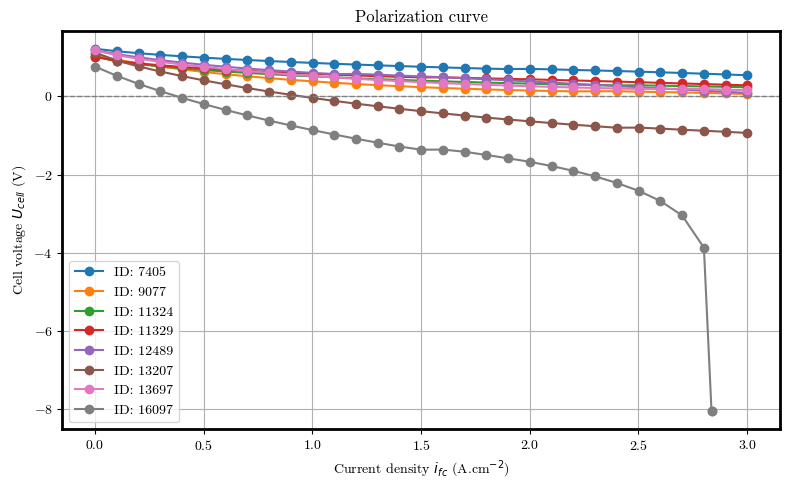

In [128]:
subset_non_mon = df_config[(df_config["classification"] == "valid") & (df_config["aprox_monotonic"] == True) & (df_config["monotonic"] == False) & (df_config["early_values_in_range"] == True)].head(10).copy().reset_index()
plot_polarization_curves(subset_non_mon)

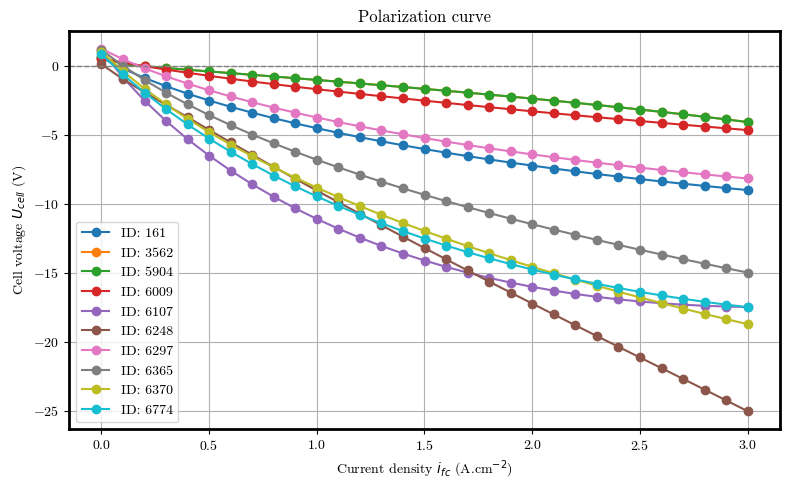

In [129]:
subset = df_config[(df_config["start_in_range"] == True) & (df_config["early_values_in_range"] == False) & (df_config["monotonic"] == True)].head(10).copy().reset_index()
plot_polarization_curves(subset)

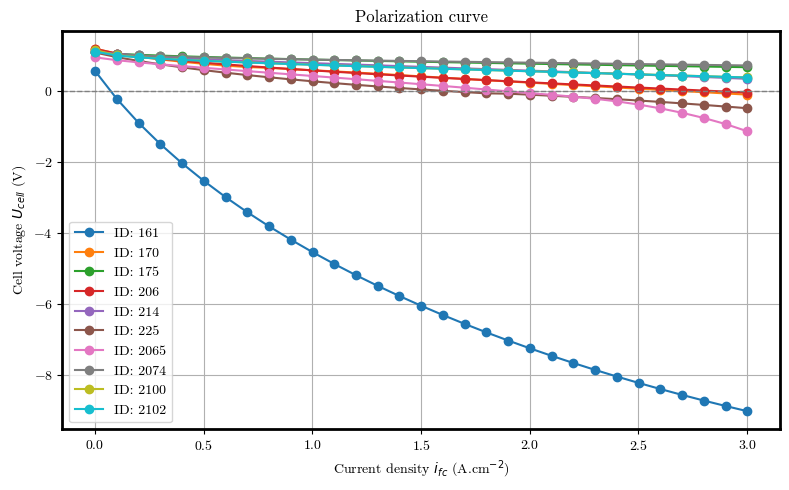

In [130]:
plot_polarization_curves(df_config[df_config["classification"] == "valid"].head(10).reset_index())

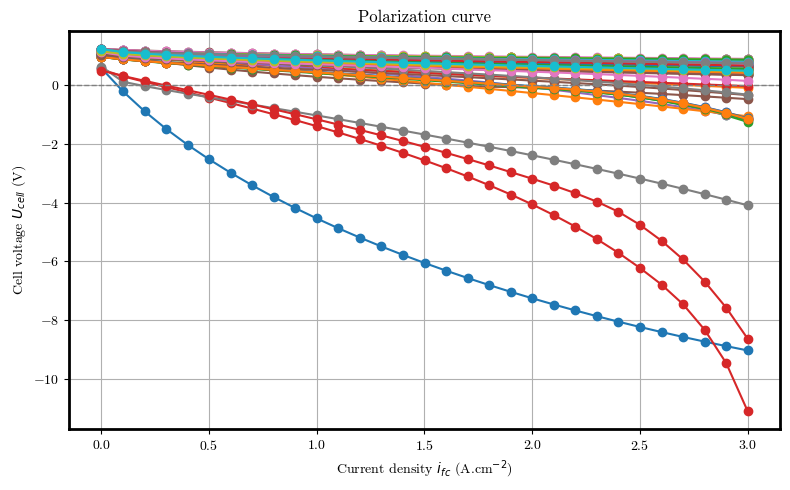

In [131]:
plot_polarization_curves(df_config[df_config["classification"] == "valid"].head(100).reset_index(), print_legend=False)

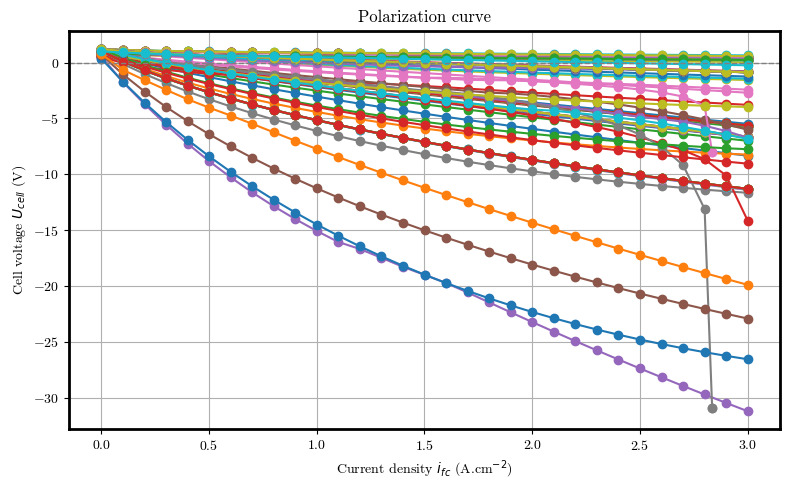

In [ ]:
plot_polarization_curves(df_config[df_config["classification"] == "valid"].tail(100).reset_index(), print_legend=False)

## Save the samples

In [ ]:
today_str = date.today().isoformat()  # Format: YYYY-MM-DD

output_dir = os.path.join("../data", "processed")
os.makedirs(output_dir, exist_ok=True)

full_filename_base = f"all_sampled_configurations_until_{today_str}"
df_config.to_pickle(os.path.join(output_dir, full_filename_base + ".pkl"))
df_config.to_csv(os.path.join(output_dir, full_filename_base + ".csv"), index=True)

print("Saved full df_config to:")
print(f"  - {full_filename_base}.pkl")
print(f"  - {full_filename_base}.csv")

Saved full df_config to:
  - all_sampled_configurations_until_2025-06-15.pkl
  - all_sampled_configurations_until_2025-06-15.csv


### Save the samples for the IRD

The imbalance between the two classes needs to be addressed.

In [137]:
df_config["classification"].value_counts()

classification
invalid    14497
valid        574
Name: count, dtype: int64

In [138]:
# Variables to keep for the IRD analysis
summary_vars = (
    ls_operating_conditions +
    ls_undetermined_physical_parameters +
    ["start_in_range", "early_values_in_range", "monotonic", "aprox_monotonic", "classification"]
)

df_ird = df_config[summary_vars].copy()
df_ird = df_ird.reset_index(drop=True)  # Remove index

In [139]:
df_ird.head()

,Tfc,Pa_des,Pc_des,Sa,Sc,Phi_a_des,Phi_c_des,epsilon_gdl,tau,epsilon_mc,...,kappa_co,kappa_c,a_slim,b_slim,a_switch,start_in_range,early_values_in_range,monotonic,aprox_monotonic,classification
0,350.733907,254576.953326,252576.953326,1.3,1.965843,0.5,0.526908,0.654882,2.200366,0.237799,...,23.018893,56.178067,0.500886,0.362783,0.498864,False,False,True,True,invalid
1,345.666812,191995.755332,189995.755332,1.3,2.194138,0.5,0.542105,0.682802,2.059682,0.230037,...,22.595591,36.922855,0.411585,0.611276,0.720162,False,False,True,True,invalid
2,343.601126,212985.109250,210985.109250,1.3,2.397039,0.5,0.252432,0.643588,1.862864,0.315966,...,20.742342,69.083870,0.380976,0.373063,0.608558,False,False,True,True,invalid
3,342.947626,245481.210389,243481.210389,1.3,1.915101,0.5,0.279978,0.645266,3.120027,0.246619,...,18.782400,38.165799,0.422645,0.557174,0.431175,False,False,True,True,invalid
4,354.654792,228129.457509,226129.457509,1.3,2.082688,0.5,0.405088,0.633711,2.793449,0.317232,...,19.948737,66.353203,0.251690,0.702215,0.341081,False,False,True,True,invalid


In [141]:
# 1. Separate valid and invalid configurations
df_valid = df_ird[df_ird["classification"] == "valid"].copy()
df_invalid = df_ird[df_ird["classification"] != "valid"].copy()

# Drop NaNs just in case (on input variables only)
df_invalid = df_invalid.dropna(subset=ls_operating_conditions + ls_undetermined_physical_parameters)

# 2. Scale input variables to [0, 1] for KMeans
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_invalid[ls_operating_conditions + ls_undetermined_physical_parameters])

# 3. Set number of clusters to number of valid examples (automatically)
n_valid = len(df_valid)
n_clusters = n_valid

# 4. Run KMeans on the invalid configs
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
kmeans.fit(X_scaled)

# 5. Select one sample closest to each cluster center
df_invalid["cluster"] = kmeans.labels_
representative_idxs = (
    df_invalid.groupby("cluster", group_keys=False)
    .apply(lambda x: x.sample(1, random_state=42))
    .index
)
df_sampled_invalid = df_invalid.loc[representative_idxs].drop(columns=["cluster"])

# 6. Combine with all valid configs
df_balanced = pd.concat([df_valid, df_sampled_invalid], ignore_index=True)

print(f"Selected {len(df_valid)} valid and {len(df_sampled_invalid)} diverse invalid samples.")
print("Balanced dataset shape:", df_balanced.shape)


Selected 574 valid and 574 diverse invalid samples.
Balanced dataset shape: (1148, 24)


C:\Users\User\AppData\Local\Temp\ipykernel_8304\1265645957.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=42))


In [144]:
# Save as CSV with float precision maintained (especially for "Re")
ird_filename_base = f"configurations_for_IRD_until_{today_str}"
df_balanced.to_csv(os.path.join(output_dir, ird_filename_base + ".csv"), index=False, float_format="%.18e")
df_balanced.to_pickle(os.path.join(output_dir, ird_filename_base + ".pkl"))

print("Saved IRD-compatible summary to:")
print(f"  - {ird_filename_base}.csv")
print(f"  - {ird_filename_base}.pkl")

Saved IRD-compatible summary to:
  - configurations_for_IRD_until_2025-06-15.csv
  - configurations_for_IRD_until_2025-06-15.pkl
